In [1]:
pip install biopython pandas numpy matplotlib seaborn logomaker

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
from Bio import SeqIO, motifs
from Bio.Seq import Seq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logomaker
import random

In [2]:
random.seed(35)
plt.rcParams["figure.dpi"] = 120
sns.set_style("whitegrid")

In [3]:
genome_file = "C:/Users/Meghana/Desktop/Genomics/NCBI_Data/210707L_GCA_900475505.1/ncbi_dataset/data/GCA_900475505.1/GCA_900475505.1_42925_G01_genomic.fna"
gff_file    = "C:/Users/Meghana/Desktop/Genomics/NCBI_Data/210707L_GCA_900475505.1/ncbi_dataset/data/GCA_900475505.1/genomic.gff"

genome_record = SeqIO.read(genome_file, "fasta")
genome_seq = str(genome_record.seq)

gff_cols = ["seqid", "source", "type", "start", "end", "score", "strand", "phase", "attributes"]
gff_df = pd.read_csv(gff_file, sep="\t", comment="#", names=gff_cols)
print(f"✅ Loaded genome: {genome_record.id} | Annotated entries: {len(gff_df)}")

✅ Loaded genome: LS483385.1 | Annotated entries: 4565


In [4]:
def extract_upstream_regions(genome_seq, gff_df):
    genes = gff_df[gff_df["type"] == "gene"]
    upstream = []

    for _, row in genes.iterrows():
        start = int(row["start"]) - 1
        if row["strand"] == "+":
            seq = genome_seq[max(0, start - 15): max(0, start - 5)]
        else:
            seq = genome_seq[start + 5: start + 15]
            seq = str(Seq(seq).reverse_complement())
        if len(seq) == 10:
            upstream.append(seq)
    return upstream

In [5]:
def detect_promoters(genome_seq, gff_df):
    upstream = extract_upstream_regions(genome_seq, gff_df)
    selected = random.sample(upstream, 1100)
    promoters = []

    while len(promoters) < 10:  # ensure at least 10
        promoters = []
        selected = random.sample(upstream, 1100)
        for seq in selected[:100]:
            for i in range(len(seq) - 5):
                win = seq[i:i+6]
                if all(b in "AT" for b in win) and win[1] == "A" and win[-1] == "T":
                    promoters.append(win)
        if len(promoters) >= 10:
            break
    return promoters, selected

promoter_seqs, upstream_1100 = detect_promoters(genome_seq, gff_df)
print(f"🔍 Promoter-like 6-mers detected: {len(promoter_seqs)}")

🔍 Promoter-like 6-mers detected: 11


In [6]:
def build_ppm(promoter_list):
    motif = motifs.create([Seq(i) for i in promoter_list])
    for i in range(6):
        for base in "ATCG":
            if motif.counts[base][i] == 0:
                motif.counts[base][i] = 0.001
    ppm = motif.counts.normalize()
    consensus = motif.consensus
    # Compute consensus score (approximate log-prob)
    cscore = np.log(np.prod([ppm[b, i] for i, b in enumerate(consensus)]))
    return ppm, consensus, cscore

ppm, consensus, consensus_score = build_ppm(promoter_seqs)
print(f"🧩 Consensus motif: {consensus}")
print(f"📊 Consensus score: {consensus_score:.4f}")

🧩 Consensus motif: TATTAT
📊 Consensus score: -2.4258


In [7]:
def statistical_alignment(upstream, ppm, cscore):
    norm_scores = {}
    for idx, seq in enumerate(upstream[100:]):  # next 1000
        seq_scores = {}
        for i in range(len(seq) - 5):
            win = seq[i:i+6]
            window_score = np.prod([ppm[win[j], j] for j in range(6)])
            seq_scores[win] = np.log(window_score) - cscore
        norm_scores[idx] = seq_scores
    return norm_scores

norm_score = statistical_alignment(upstream_1100, ppm, consensus_score)

<Figure size 960x360 with 0 Axes>

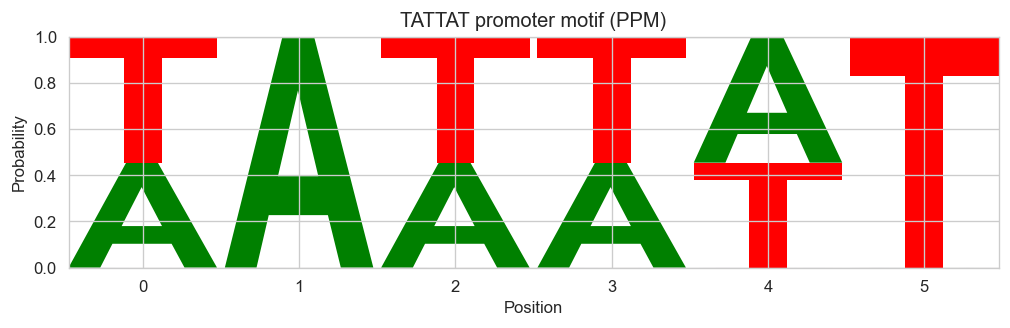

In [8]:
df_ppm = pd.DataFrame(ppm, columns=['A','C','G','T'])
plt.figure(figsize=(8,3))
logomaker.Logo(df_ppm, color_scheme='classic')
plt.title(f"{consensus} promoter motif (PPM)")
plt.xlabel("Position")
plt.ylabel("Probability")
plt.show()

In [9]:
print("\nPosition Probability Matrix (rounded):")
display(df_ppm.round(4))


Position Probability Matrix (rounded):


,A,C,G,T
0,0.4545,0.0001,0.0001,0.5454
1,0.9997,0.0001,0.0001,0.0001
2,0.4545,0.0001,0.0001,0.5454
3,0.4545,0.0001,0.0001,0.5454
4,0.5454,0.0001,0.0001,0.4545
5,0.0001,0.0001,0.0001,0.9997


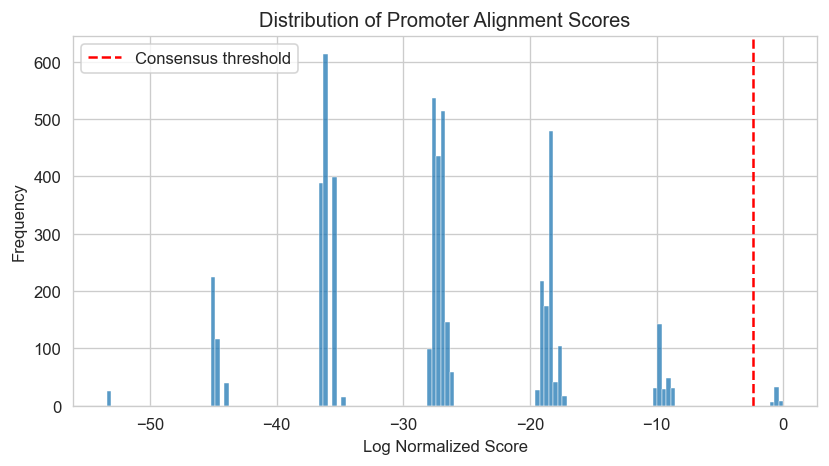

In [10]:
all_scores = [score for seq in norm_score.values() for score in seq.values()]
plt.figure(figsize=(8,4))
sns.histplot(all_scores, bins=150, kde=False)
plt.axvline(consensus_score, color='r', linestyle='--', label='Consensus threshold')
plt.xlabel("Log Normalized Score")
plt.ylabel("Frequency")
plt.title("Distribution of Promoter Alignment Scores")
plt.legend()
plt.show()

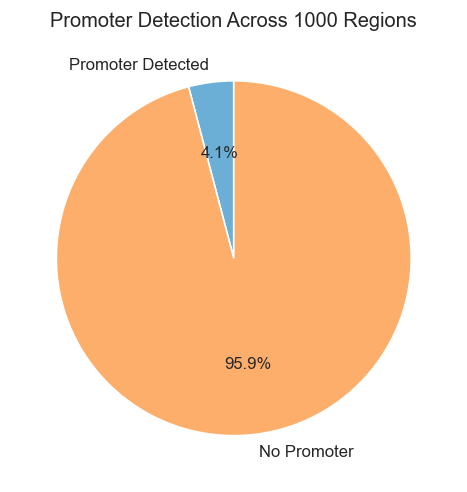

In [11]:
presence = [any(v > consensus_score for v in s.values()) for s in norm_score.values()]
plt.figure()
plt.pie([sum(presence), len(presence)-sum(presence)], 
        labels=["Promoter Detected","No Promoter"],
        autopct="%1.1f%%", startangle=90, colors=["#6baed6","#fdae6b"])
plt.title("Promoter Detection Across 1000 Regions")
plt.show()

In [ ]:
def cross_validation_fixed(genome_files, gff_files, ids, base_ppm, base_consensus_score):

    promoter_counts, all_scores_list = [], []

    for gen, gff, sid in zip(genome_files, gff_files, ids):
        print(f"\n=== Cross Validation using 210707L PPM for {sid} ===")
        
        genome = str(SeqIO.read(gen, "fasta").seq)
        gff_df = pd.read_csv(gff, sep="\t", comment="#", names=gff_cols)

        # Extract upstream regions and take the first 1000
        upstream = extract_upstream_regions(genome, gff_df)
        if len(upstream) > 1000:
            upstream = upstream[:1000]  # Limit to 1000 regions as per assignment

        # Perform statistical alignment using your own PPM
        norm = statistical_alignment(upstream, base_ppm, base_consensus_score)

        # Determine promoter presence based on threshold
        presence = [any(v > base_consensus_score for v in s.values()) for s in norm.values()]
        detected = sum(presence)
        promoter_counts.append(detected)
        all_scores = [score for seq_scores in norm.values() for score in seq_scores.values()]
        all_scores_list.append((sid, all_scores))

        print(f"Total annotated genes: {len(gff_df)}")
        print(f"Analyzed upstream regions: {len(upstream)}")
        print(f"Promoter-like regions detected: {detected} ({detected/len(upstream)*100:.2f}%)")

        # Pie chart for promoter detection
        plt.figure(figsize=(6,4))
        plt.pie([detected, len(upstream)-detected],
                labels=["Promoter Detected","No Promoter"],
                autopct="%1.1f%%", startangle=90, colors=["#6baed6","#fdae6b"])
        plt.title(f"Promoter Detection in {sid} (using 210707L PPM)")
        plt.show()

    # --- Combined histograms ---
    fig, axes = plt.subplots(len(ids), 1, figsize=(10, len(ids)*3))
    if len(ids) == 1:
        axes = [axes]
    for ax, (sid, scores) in zip(axes, all_scores_list):
        sns.histplot(scores, bins=150, ax=ax, color="purple")
        ax.axvline(base_consensus_score, color="r", linestyle="--", label="Promoter Threshold")
        ax.set_title(f"{sid}: Score Distribution (using 210707L PPM)")
        ax.legend()
    plt.tight_layout()
    plt.show()

    # --- Summary of promoter counts ---
    plt.figure(figsize=(8,4))
    plt.bar(ids, promoter_counts, color="#9ecae1")
    plt.title("Cross-validation: Promoter-like regions detected in 1000 upstream regions (using 210707L PPM)")
    plt.ylabel("Detected promoter regions (count)")
    plt.show()



=== Cross Validation using 210707L PPM for 210079K ===
Total annotated genes: 4354
Analyzed upstream regions: 1000
Promoter-like regions detected: 48 (4.80%)


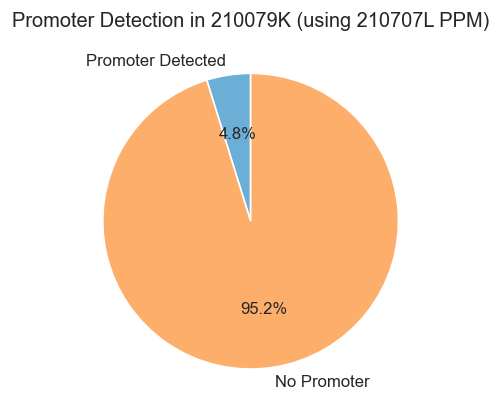


=== Cross Validation using 210707L PPM for 210179R ===
Total annotated genes: 4080
Analyzed upstream regions: 1000
Promoter-like regions detected: 46 (4.60%)


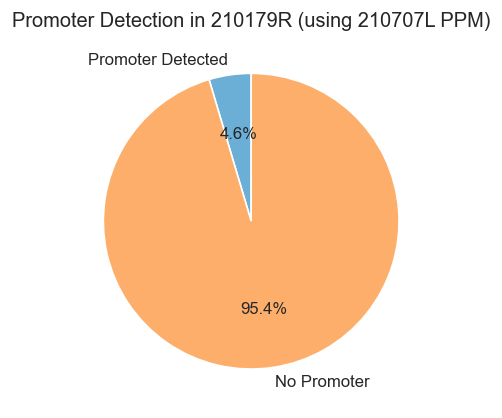


=== Cross Validation using 210707L PPM for 210504L ===
Total annotated genes: 3939
Analyzed upstream regions: 1000
Promoter-like regions detected: 49 (4.90%)


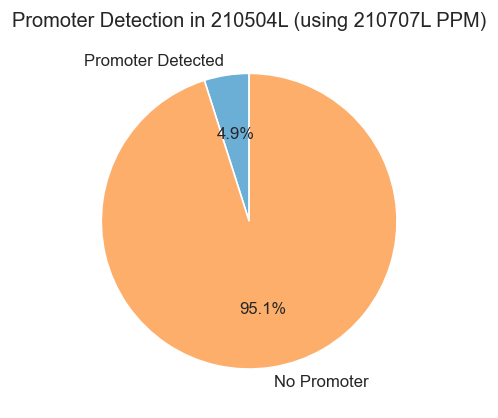


=== Cross Validation using 210707L PPM for 210657G ===
Total annotated genes: 3795
Analyzed upstream regions: 1000
Promoter-like regions detected: 40 (4.00%)


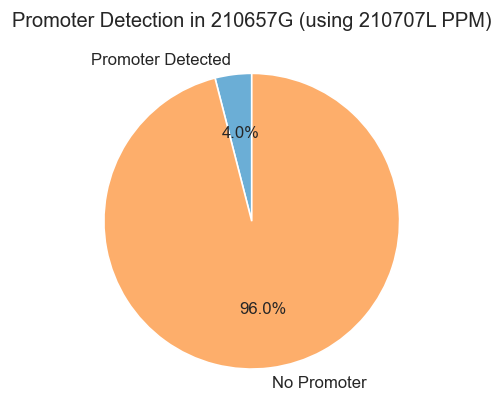


=== Cross Validation using 210707L PPM for 210732H ===
Total annotated genes: 4309
Analyzed upstream regions: 1000
Promoter-like regions detected: 53 (5.30%)


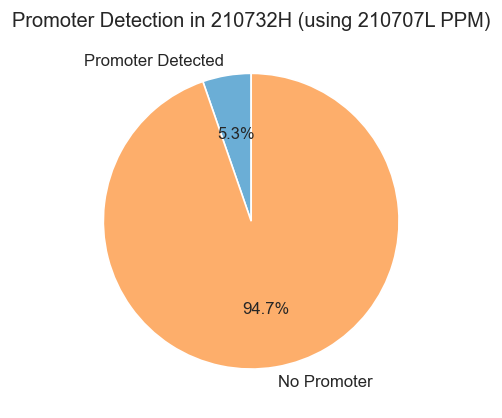

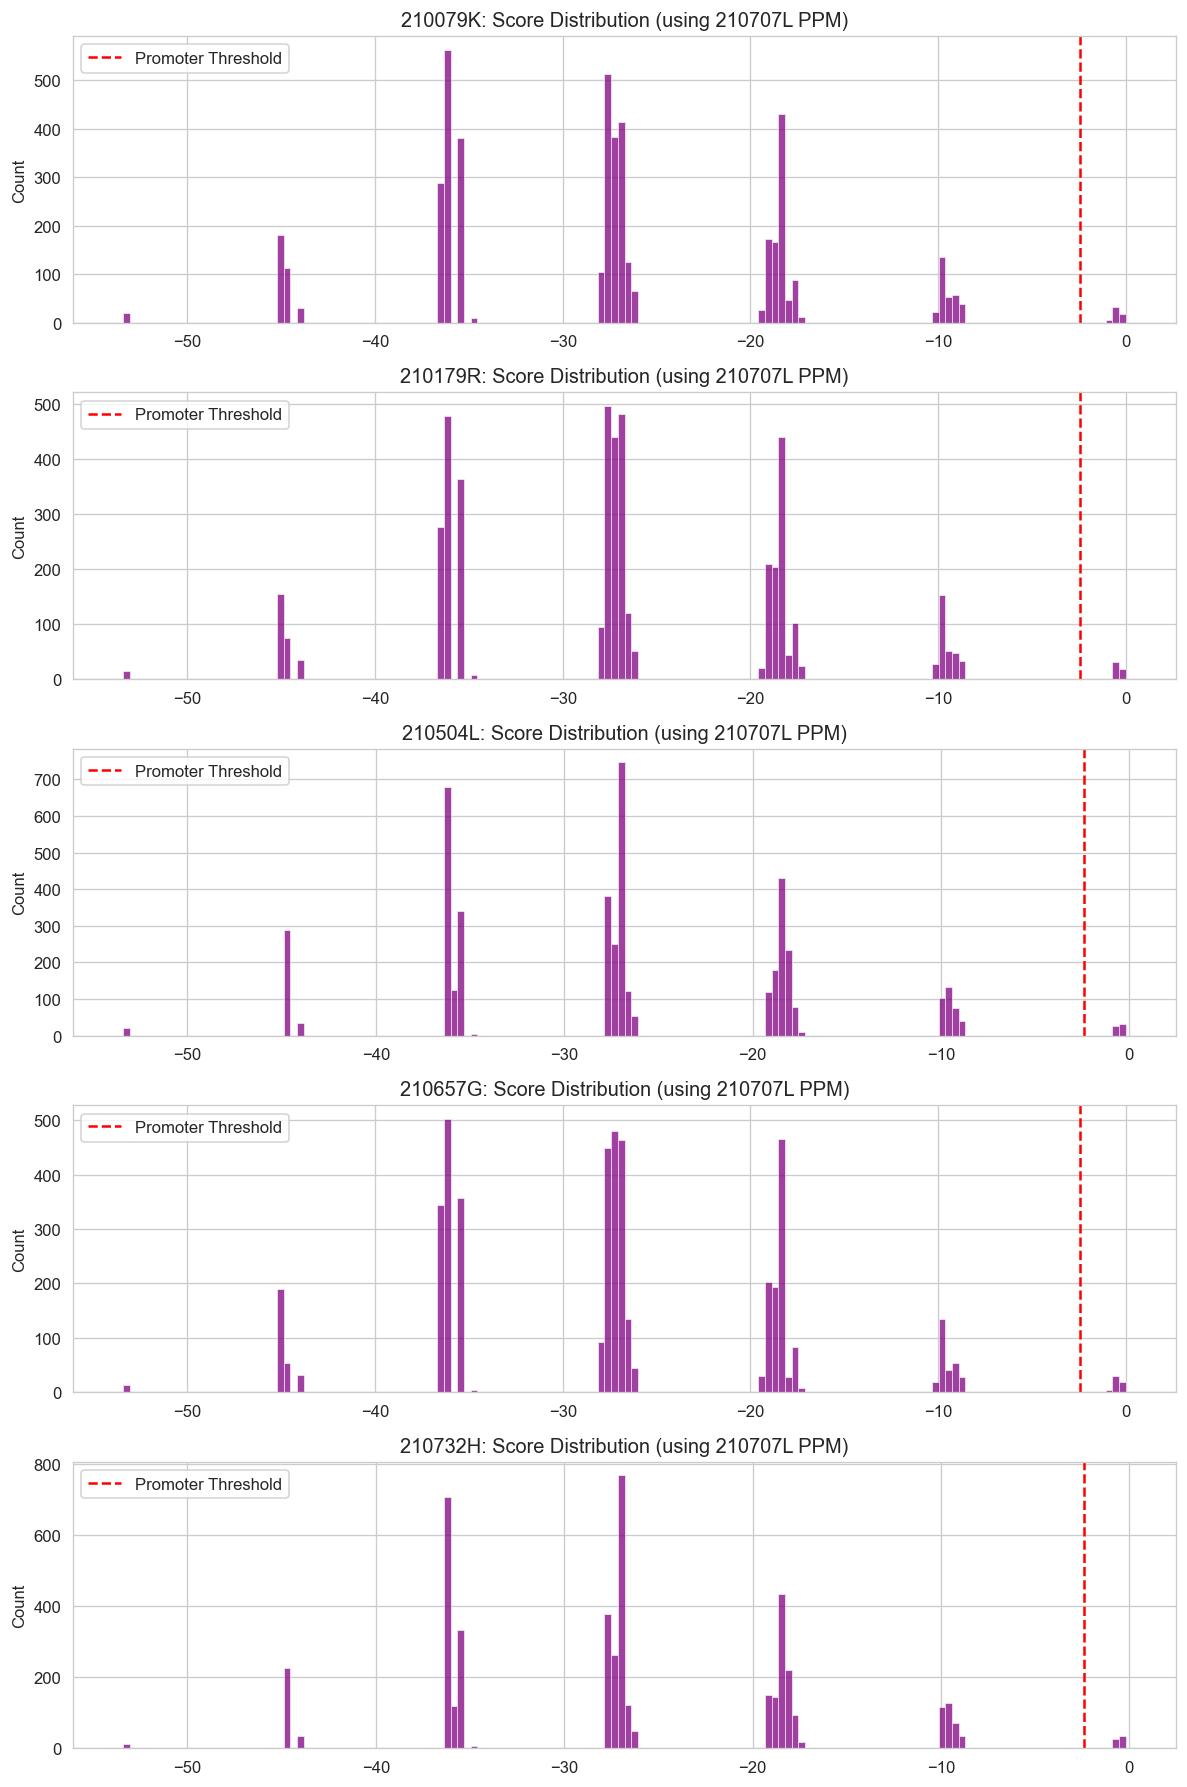

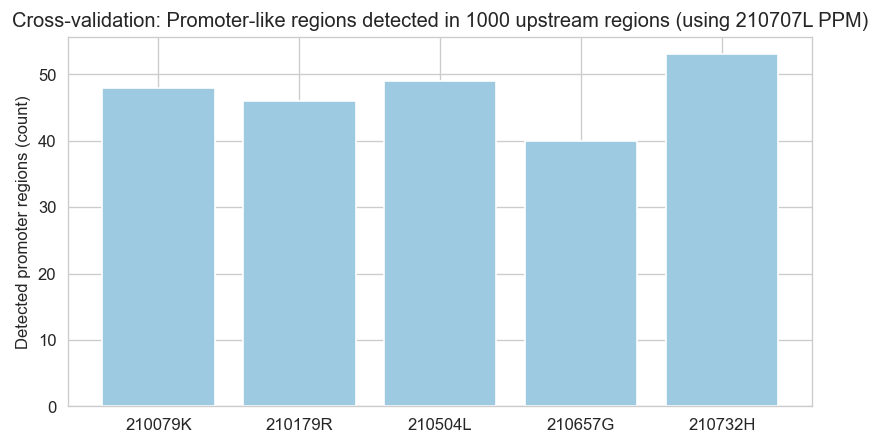

In [18]:
genome_files = [
    "NCBI_Data/210079K_GCA_001457635.1/ncbi_dataset/data/GCA_001457635.1/GCA_001457635.1_NCTC7465_genomic.fna",
    "NCBI_Data/210179R_GCA_019048645.1/ncbi_dataset/data/GCA_019048645.1/GCA_019048645.1_ASM1904864v1_genomic.fna",
    "NCBI_Data/210504L_GCA_900636475.1/ncbi_dataset/data/GCA_900636475.1/GCA_900636475.1_42197_F01_genomic.fna",
    "NCBI_Data/210657G_GCA_900637025.1/ncbi_dataset/data/GCA_900637025.1/GCA_900637025.1_46338_H01_genomic.fna",
    "NCBI_Data/210732H_GCA_019046945.1/ncbi_dataset/data/GCA_019046945.1/GCA_019046945.1_ASM1904694v1_genomic.fna"
]

gff_files = [
    "NCBI_Data/210079K_GCA_001457635.1/ncbi_dataset/data/GCA_001457635.1/genomic.gff",
    "NCBI_Data/210179R_GCA_019048645.1/ncbi_dataset/data/GCA_019048645.1/genomic.gff",
    "NCBI_Data/210504L_GCA_900636475.1/ncbi_dataset/data/GCA_900636475.1/genomic.gff",
    "NCBI_Data/210657G_GCA_900637025.1/ncbi_dataset/data/GCA_900637025.1/genomic.gff",
    "NCBI_Data/210732H_GCA_019046945.1/ncbi_dataset/data/GCA_019046945.1/genomic.gff"
]

ids = ["210079K", "210179R", "210504L", "210657G", "210732H"]
base_ppm=ppm
base_consensus_score=consensus_score

# Now run cross-validation
cross_validation_fixed(genome_files, gff_files, ids, base_ppm, base_consensus_score)
